In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('utils/')
from data_utils import get_image_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=8,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

827784

# Train

In [10]:
from torch.optim.lr_scheduler import MultiStepLR

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = MultiStepLR(
    optimizer, 
    [10, 17]
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
all_losses = train(
    model, criterion, optimizer,
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=8, threshold=0.01, # early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.320 3.968  0.097 0.134  0.270 0.357  434.469
1  3.469 3.556  0.206 0.191  0.475 0.457  427.053
2  3.142 3.348  0.265 0.227  0.550 0.507  428.674
3  2.951 3.114  0.301 0.271  0.594 0.557  429.048
4  2.802 2.922  0.329 0.306  0.626 0.603  427.898
5  2.713 2.842  0.349 0.333  0.643 0.627  428.584
6  2.630 2.949  0.367 0.312  0.661 0.606  427.710
7  2.577 2.707  0.377 0.347  0.670 0.649  429.878
8  2.522 2.898  0.389 0.331  0.680 0.621  427.630
9  2.491 2.635  0.394 0.370  0.688 0.664  427.049
10  2.453 2.618  0.405 0.371  0.695 0.670  424.802
11  1.895 1.849  0.529 0.546  0.790 0.796  422.832
12  1.729 1.807  0.566 0.551  0.816 0.801  421.031
13  1.670 1.780  0.578 0.557  0.825 0.804  421.637
14  1.622 1.797  0.588 0.551  0.832 0.803  420.595
15  1.593 1.781  0.595 0.553  0.836 0.804  419.834
16  1.567 1.756  0.602 0.562  0.840 0.808  421.645
17  1.552 1.791  0.603 0.548  0.843 0.802  421.661
18  1.355 1.578  0.653 0.606  0.871 0.834  421.548
19  1.299 1.568  0.667 0.610  0.879 0.835

# Loss/epoch plots

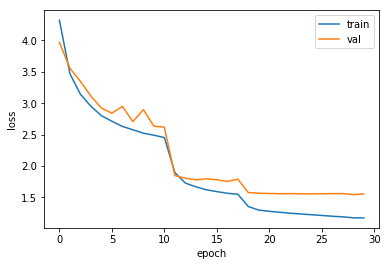

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

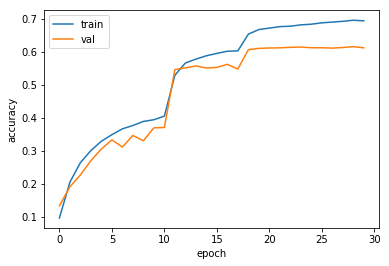

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

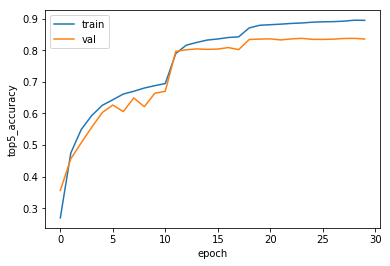

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')